In [1]:
!pip install transformers --quiet
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Raouf Ks
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection


100%|██████████| 3.30M/3.30M [00:00<00:00, 782MB/s]

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Available Device is: ", device)

Available Device is:  cuda


## Dataset
Load and explore the sarcasm detection dataset. We'll read the JSON file, remove missing values, and visualize the first few records to understand the data structure.

In [3]:
data_df = pd.read_json("/content/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json", lines=True)
data_df.dropna(inplace=True)
print(data_df.shape)
data_df.head()

(26709, 3)


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


## Data splitting
Split the dataset into training (70%), validation (15%), and testing (15%) sets using scikit-learn's train_test_split function to properly evaluate model performance.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(np.array(data_df["headline"]), np.array(data_df["is_sarcastic"]), test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [5]:
print("Training set is: ", X_train.shape[0], " rows which is ", round(X_train.shape[0]/data_df.shape[0],4)*100, "%")
print("Validation set is: ",X_val.shape[0], " rows which is ", round(X_val.shape[0]/data_df.shape[0],4)*100, "%")
print("Testing set is: ",X_test.shape[0], " rows which is ", round(X_test.shape[0]/data_df.shape[0],4)*100, "%")

Training set is:  18696  rows which is  70.0 %
Validation set is:  4006  rows which is  15.0 %
Testing set is:  4007  rows which is  15.0 %


## Download Model and tokenizer
Download the pre-trained BERT model (bert-base-uncased) and its corresponding tokenizer from Hugging Face. Always match the tokenizer with the model to ensure proper text encoding.

In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## Dataset object
Create custom PyTorch Dataset classes for training, validation, and testing data. The tokenizer will convert text into tokens with proper padding and truncation for BERT.

In [7]:
class dataset(Dataset):
    def __init__(self, X, Y):
        self.X = [tokenizer(x,
                            max_length = 100,
                            truncation = True,
                            padding = 'max_length',
                            return_tensors='pt').to(device)
                  for x in X
                 ]

        self.Y = torch.tensor(Y, dtype = torch.float32).to(device)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

## Training Hyper Parameters
Define the training configuration including batch size (32), number of epochs (25), and learning rate (1e-4) for the Adam optimizer.

In [9]:
BATCH_SIZE = 32
EPOCHS = 25
LR = 1e-4

## Data loader
Create PyTorch DataLoader objects for efficient batch processing during training, validation, and testing with shuffling enabled.

In [10]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle= True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle= True)
testing_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle= True)

## Model Class
Define a custom model that combines the BERT backbone with a classification head: two linear layers with dropout for binary classification (Sarcastic vs. Not Sarcastic).

In [11]:
class MyModel(nn.Module):
    def __init__(self, bert):

        super(MyModel, self).__init__()

        self.bert = bert
        self.dropout = nn.Dropout(0.25)
        self.linear1 = nn.Linear(768, 384)
        self.linear2 = nn.Linear(384, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(input_ids, attention_mask, return_dict = False)[0][:,0]
        output = self.linear1(pooled_output)
        output = self.dropout(output)
        output = self.linear2(output)
        output = self.sigmoid(output)
        return output

## Pretraining
Freeze BERT weights to preserve the pre-trained knowledge and only train the custom classification head. Then initialize the model on the device (GPU/CPU).

In [12]:
for param in bert_model.parameters():
    param.requires_grad = False
model = MyModel(bert_model).to(device)

## Loss and Optimizer
Set up Binary Cross Entropy (BCELoss) as the loss function and Adam optimizer with learning rate 1e-4 for gradient-based optimization.

In [13]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr= LR)

## Training loop
Execute the main training loop for 25 epochs. For each epoch, train on the training data and validate on the validation set, tracking loss and accuracy metrics throughout.

In [14]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0
    ## Training and Validation
    for indx, data in enumerate(train_dataloader):
        input, label = data

        input.to(device)
        label.to(device)

        prediction = model(input['input_ids'].squeeze(1),
                            input['attention_mask'].squeeze(1)).squeeze(1)


        batch_loss = criterion(prediction, label)

        total_loss_train += batch_loss.item()

        acc = ((prediction).round() == label).sum().item()
        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    ## Validation
    with torch.no_grad():
        for indx, data in enumerate(validation_dataloader):
            input, label = data
            input.to(device)
            label.to(device)

            prediction = model(input['input_ids'].squeeze(1),
                            input['attention_mask'].squeeze(1)).squeeze(1)

            batch_loss_val = criterion(prediction, label)
            total_loss_val += batch_loss_val.item()


            acc = ((prediction).round() == label).sum().item()

            total_acc_val += acc


    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/100, 4))
    total_acc_train_plot.append(round(total_acc_train/(training_data.__len__())*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/(validation_data.__len__())*100, 4))

    print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(training_data.__len__())*100):.4f} Validation Loss: {total_loss_val/100:.4f} Validation Accuracy: {(total_acc_val/(validation_data.__len__())*100):.4f}''')
    print("="*50)


Epoch no. 1 Train Loss: 0.2599 Train Accuracy: 80.2471 Validation Loss: 0.4716 Validation Accuracy: 83.8992
Epoch no. 2 Train Loss: 0.2121 Train Accuracy: 84.6759 Validation Loss: 0.4302 Validation Accuracy: 84.7728
Epoch no. 3 Train Loss: 0.2000 Train Accuracy: 85.5424 Validation Loss: 0.4199 Validation Accuracy: 85.6216
Epoch no. 4 Train Loss: 0.1932 Train Accuracy: 85.7831 Validation Loss: 0.4145 Validation Accuracy: 85.6965
Epoch no. 5 Train Loss: 0.1880 Train Accuracy: 86.2217 Validation Loss: 0.4215 Validation Accuracy: 85.3719
Epoch no. 6 Train Loss: 0.1855 Train Accuracy: 86.3768 Validation Loss: 0.4094 Validation Accuracy: 85.7713
Epoch no. 7 Train Loss: 0.1832 Train Accuracy: 86.6977 Validation Loss: 0.4040 Validation Accuracy: 86.0709
Epoch no. 8 Train Loss: 0.1809 Train Accuracy: 86.8207 Validation Loss: 0.4032 Validation Accuracy: 86.2456
Epoch no. 9 Train Loss: 0.1808 Train Accuracy: 86.8047 Validation Loss: 0.4009 Validation Accuracy: 86.7698
Epoch no. 10 Train Loss: 0.1

## Testing
Evaluate the trained model on the test set without gradient computation. Calculate the final accuracy score to assess the model's generalization performance.

In [16]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, data in enumerate(testing_dataloader):
    input, label = data
    input.to(device)
    label.to(device)

    prediction = model(input['input_ids'].squeeze(1), input['attention_mask'].squeeze(1)).squeeze(1)

    batch_loss_val = criterion(prediction, label)
    total_loss_test += batch_loss_val.item()
    acc = ((prediction).round() == label).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 2)}%")

Accuracy Score is: 85.68%


## Visualizations
Generate comprehensive plots showing training vs validation loss and accuracy across all epochs to visualize model convergence and detect overfitting.

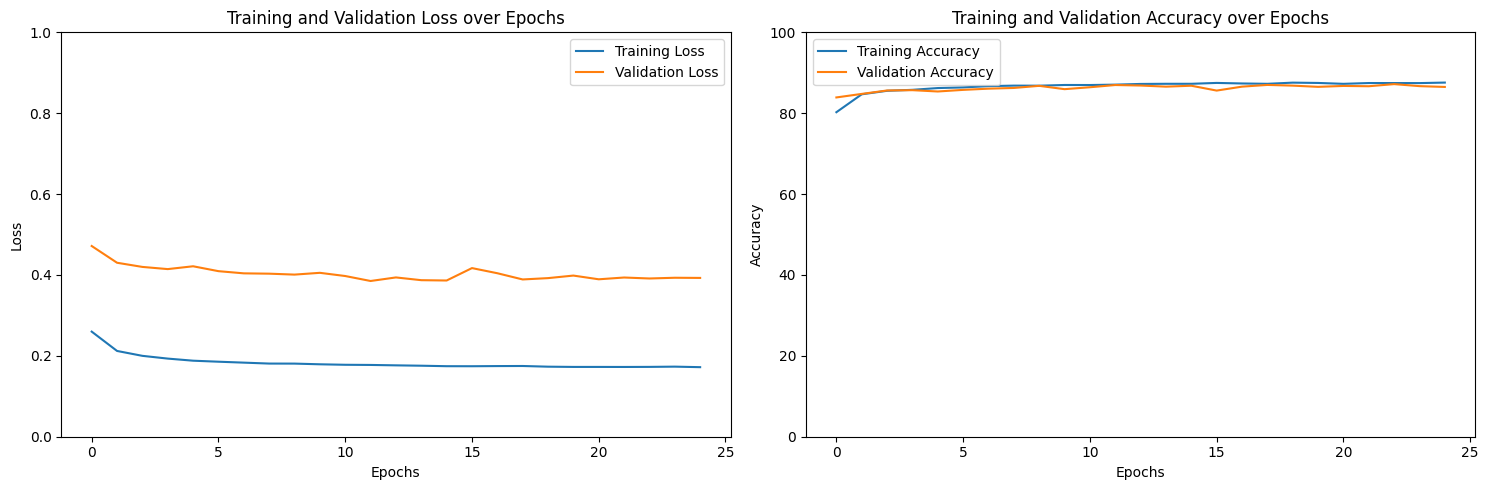

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 1])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()